Importing Libraries and Dataset(Bag level data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
filepath = "/content/drive/MyDrive/United Airlines/Bag+Level+Data.csv"

In [3]:
data = pd.read_csv(filepath)

In [4]:
data.head(5)

,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,bag_tag_unique_number,bag_tag_issue_date,bag_type
0,UA,1068,2025-08-01,ORD,IAD,BAGTAG_418666,2025-07-27,Transfer
1,UA,622,2025-08-01,ORD,DEN,BAGTAG_418667,2025-07-28,Transfer
2,YX,3718,2025-08-01,ORD,MSN,BAGTAG_84760,2025-07-28,Transfer
3,BA,294,2025-08-01,ORD,LHR,BAGTAG_418669,2025-07-28,Transfer
4,UA,2627,2025-08-01,ORD,MSP,BAGTAG_335257,2025-07-28,Transfer


In [5]:
data.shape

(687245, 8)

In [6]:
data['bag_tag_unique_number'].nunique()

667155

In [7]:
data['bag_type'].unique()

array(['Transfer', 'Origin', 'Hot Transfer'], dtype=object)

### Analysis shows that for our solution, the **"bag_type"** feature alone is sufficient to determine bag-level complexity.


# Calculating Bag-Level Complexity

In this step, we process the bag-level data to compute a complexity score for each flight:

1. **Standardize `bag_type`** – Ensure consistency in bag type names.
2. **Count bags per type** – Group by flight and bag type to get the number of bags of each type.
3. **Pivot table** – Convert bag types into separate columns (`Origin`, `Transfer`, `Hot Transfer`).
4. **Rename columns** – For clarity: `num_origin_bags`, `num_transfer_bags`, `num_hot_transfer_bags`.
5. **Calculate total bags** – Sum all bag types per flight.
6. **Compute ratios** – Proportion of transfer and hot transfer bags relative to total bags.
7. **Bag complexity score** – Weighted sum: transfer bags = 1, hot transfer bags = 2 (higher weight = more complex).

This gives us a quantitative measure of **bag-handling complexity** for each flight.


In [8]:
# Ensure bag_type is string and standardized
data['bag_type'] = data['bag_type'].astype(str).str.strip().str.title()

# Group by flight + bag_type and count bags
bag_counts = data.groupby(
    ['company_id', 'flight_number', 'scheduled_departure_date_local',
     'scheduled_departure_station_code', 'scheduled_arrival_station_code', 'bag_type']
).size().reset_index(name='count')

# Pivot to get columns per bag type
flight_bag_summary = bag_counts.pivot_table(
    index=['company_id', 'flight_number', 'scheduled_departure_date_local',
           'scheduled_departure_station_code', 'scheduled_arrival_station_code'],
    columns='bag_type',
    values='count',
    fill_value=0
).reset_index()

# Rename columns for clarity
flight_bag_summary.rename(columns={
    'Origin': 'num_origin_bags',
    'Transfer': 'num_transfer_bags',
    'Hot Transfer': 'num_hot_transfer_bags'
}, inplace=True)

# Total bags
flight_bag_summary['total_bags'] = (
    flight_bag_summary['num_origin_bags'] +
    flight_bag_summary['num_transfer_bags'] +
    flight_bag_summary['num_hot_transfer_bags']
)

# Ratios (avoid divide by zero)
flight_bag_summary['transfer_ratio'] = flight_bag_summary.apply(
    lambda x: x['num_transfer_bags'] / x['total_bags'] if x['total_bags'] > 0 else 0, axis=1
)
flight_bag_summary['hot_transfer_ratio'] = flight_bag_summary.apply(
    lambda x: x['num_hot_transfer_bags'] / x['total_bags'] if x['total_bags'] > 0 else 0, axis=1
)

# Optional: bag complexity score
flight_bag_summary['bag_complexity_score'] = (
    flight_bag_summary['num_transfer_bags']*1 + flight_bag_summary['num_hot_transfer_bags']*2
)


In [9]:
flight_bag_summary.head(5)

bag_type,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,num_hot_transfer_bags,num_origin_bags,num_transfer_bags,total_bags,transfer_ratio,hot_transfer_ratio,bag_complexity_score
0,4Y,52,2025-08-08,ORD,MSP,0.0,0.0,1.0,1.0,1.0,0.0,1.0
1,9X,305,2025-08-01,ORD,PIT,0.0,0.0,1.0,1.0,1.0,0.0,1.0
2,9X,305,2025-08-08,ORD,PIT,0.0,0.0,1.0,1.0,1.0,0.0,1.0
3,9X,330,2025-08-03,ORD,IAD,0.0,0.0,1.0,1.0,1.0,0.0,1.0
4,9X,332,2025-08-01,ORD,IAD,0.0,0.0,1.0,1.0,1.0,0.0,1.0


In [10]:
flight_bag_summary.isnull().sum()

,0
bag_type,
company_id,0
flight_number,0
scheduled_departure_date_local,0
scheduled_departure_station_code,0
scheduled_arrival_station_code,0
num_hot_transfer_bags,0
num_origin_bags,0
num_transfer_bags,0
total_bags,0


In [11]:
flight_bag_summary.duplicated().sum()

np.int64(0)

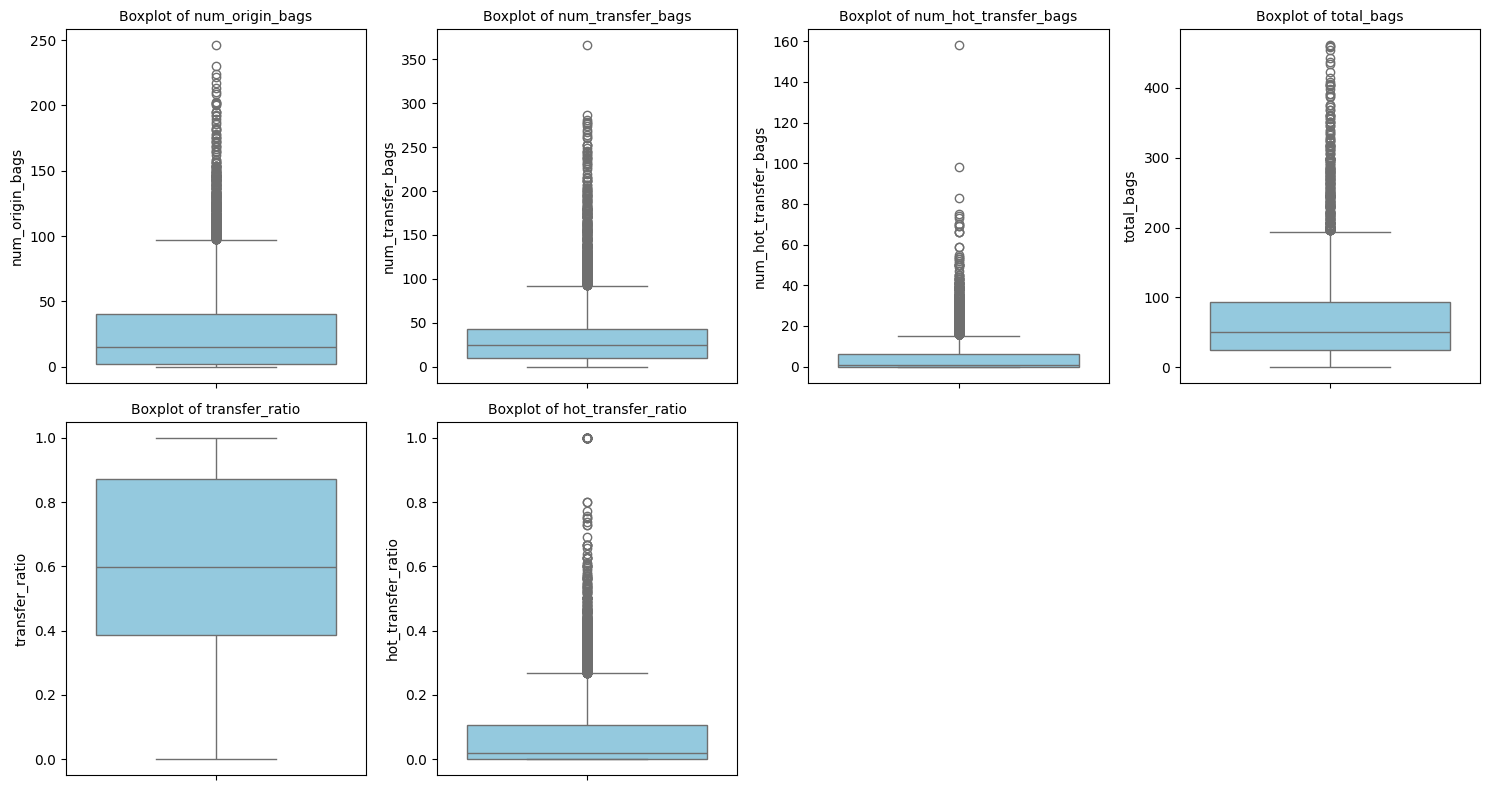

In [12]:
# Numeric columns for bag dataset
numeric_cols = [
    'num_origin_bags',
    'num_transfer_bags',
    'num_hot_transfer_bags',
    'total_bags',
    'transfer_ratio',
    'hot_transfer_ratio'
]

plt.figure(figsize=(15, 8))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=flight_bag_summary[col], color="skyblue")
    plt.title(f'Boxplot of {col}', fontsize=10)

plt.tight_layout()
plt.show()


In [13]:
flight_bag_summary.columns

Index(['company_id', 'flight_number', 'scheduled_departure_date_local',
       'scheduled_departure_station_code', 'scheduled_arrival_station_code',
       'num_hot_transfer_bags', 'num_origin_bags', 'num_transfer_bags',
       'total_bags', 'transfer_ratio', 'hot_transfer_ratio',
       'bag_complexity_score'],
      dtype='object', name='bag_type')

# Visualizing and Anaylsing data

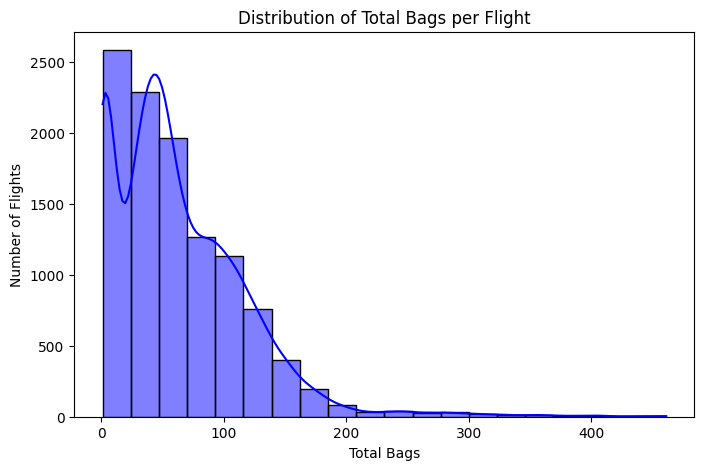

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(flight_bag_summary['total_bags'], bins=20, kde=True, color='blue')
plt.title('Distribution of Total Bags per Flight')
plt.xlabel('Total Bags')
plt.ylabel('Number of Flights')
plt.show()


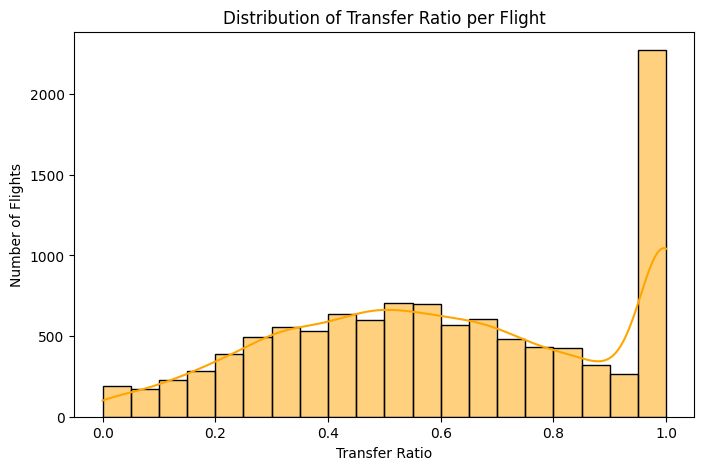

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(flight_bag_summary['transfer_ratio'], bins=20, kde=True, color='orange')
plt.title('Distribution of Transfer Ratio per Flight')
plt.xlabel('Transfer Ratio')
plt.ylabel('Number of Flights')
plt.show()


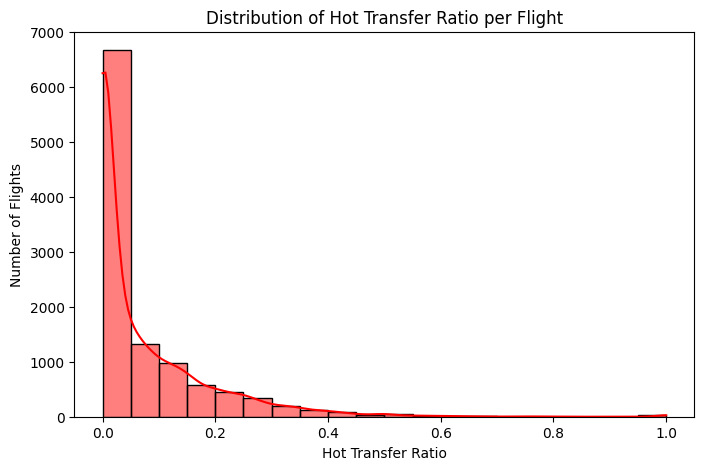

In [16]:
plt.figure(figsize=(8,5))
sns.histplot(flight_bag_summary['hot_transfer_ratio'], bins=20, kde=True, color='red')
plt.title('Distribution of Hot Transfer Ratio per Flight')
plt.xlabel('Hot Transfer Ratio')
plt.ylabel('Number of Flights')
plt.show()


# Calculating Bag Complexity Score

We compute a **quantitative bag-handling complexity** for each flight to understand which flights are more challenging in terms of baggage management.

1. **Features included and why**:
   - `total_bags_score` → more bags mean higher workload and complexity.
   - `transfer_ratio_score` → higher proportion of transfer bags requires more coordination, increasing complexity.
   - `hot_transfer_ratio_score` → hot transfer bags are urgent and most complex to handle, so they have the highest impact.

2. **Scaling** – Normalize all features to a 0–1 range for fair comparison across flights.

3. **Weighted sum** – Combine the features into a single score:
   - total bags weight = 0.3
   - transfer ratio weight = 0.3
   - hot transfer ratio weight = 0.4 (highest importance)

**Why this is necessary:** It gives a single metric per flight capturing **bag-handling difficulty**, which can then be used to prioritize resources or identify riskier flights.


In [17]:
# -------------------------------
# Features to include in bag complexity
# -------------------------------
# We will use:
# - total bags (more bags → more complexity)
# - transfer ratio (higher → more complex)
# - hot transfer ratio (highest complexity)
flight_bag_summary['total_bags_score'] = flight_bag_summary['total_bags']
flight_bag_summary['transfer_ratio_score'] = flight_bag_summary['transfer_ratio']
flight_bag_summary['hot_transfer_ratio_score'] = flight_bag_summary['hot_transfer_ratio']

# -------------------------------
# Prepare for scaling
# -------------------------------
columns_to_scale = ['total_bags_score', 'transfer_ratio_score', 'hot_transfer_ratio_score']

# Ensure numeric and handle missing or infinite values
for col in columns_to_scale:
    flight_bag_summary[col] = pd.to_numeric(flight_bag_summary[col], errors='coerce')
    flight_bag_summary[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    flight_bag_summary[col].fillna(flight_bag_summary[col].median(), inplace=True)

# -------------------------------
# Scale features 0-1
# -------------------------------
scaler = MinMaxScaler()
flight_bag_summary[columns_to_scale] = scaler.fit_transform(flight_bag_summary[columns_to_scale])

# -------------------------------
# Weighted sum to calculate Bag Complexity
# -------------------------------
weights = {
    'total_bags_score': 0.3,
    'transfer_ratio_score': 0.3,
    'hot_transfer_ratio_score': 0.4
}

flight_bag_summary['bag_complexity_score'] = sum(
    flight_bag_summary[col] * w for col, w in weights.items()
)

/tmp/ipython-input-3995019380.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  flight_bag_summary[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-3995019380.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(val

In [18]:
flight_bag_summary[['company_id', 'flight_number', 'scheduled_departure_date_local',
                          'scheduled_departure_station_code', 'scheduled_arrival_station_code',
                          'bag_complexity_score']].head()

bag_type,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,bag_complexity_score
0,4Y,52,2025-08-08,ORD,MSP,0.3
1,9X,305,2025-08-01,ORD,PIT,0.3
2,9X,305,2025-08-08,ORD,PIT,0.3
3,9X,330,2025-08-03,ORD,IAD,0.3
4,9X,332,2025-08-01,ORD,IAD,0.3


In [19]:
flight_bag_summary.to_csv('flight_bag_summary.csv', index=False)
